In [24]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import cv2
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtBase
import os
import csv


In [ ]:
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/challenge_deep"

AGREED_BOXES_CSV = os.path.join(base_dir, "agreed_boxes.csv")
BACKGROUND_BOXES_CSV = os.path.join(base_dir, "random_background_boxes.csv")
IMAGES_FOLDER = os.path.join(base_dir, "data")  

print("AGREED_BOXES_CSV:", AGREED_BOXES_CSV)
print("BACKGROUND_BOXES_CSV:", BACKGROUND_BOXES_CSV)
print("IMAGES_FOLDER:", IMAGES_FOLDER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AGREED_BOXES_CSV: /content/drive/MyDrive/challenge_deep/agreed_boxes.csv
BACKGROUND_BOXES_CSV: /content/drive/MyDrive/challenge_deep/random_background_boxes.csv
IMAGES_FOLDER: /content/drive/MyDrive/challenge_deep/data


In [ ]:
output_csv = 'output.csv'
header = ["image_name", "label","x_center", "y_center", "width", "height"]

rows = []

for filename in os.listdir(IMAGES_FOLDER):
    if filename.endswith('.txt'):
        file_id = os.path.splitext(filename)[0]
        txt_path = os.path.join(IMAGES_FOLDER, filename)

        with open(txt_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        for line in lines:
            tokens = line.strip().split()
            if len(tokens) < 5:
                print(f"Warning: Skipping invalid line in {filename}: {line}")
                continue

            label = tokens[0]
            project_name = " ".join(tokens[1:-4])
            x_center, y_center, width, height = tokens[-4:]

            rows.append([
                file_id,  
                label,
                #project_name,
                x_center,
                y_center,
                width,
                height
            ])

with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=';')
    csvwriter.writerow(header)
    csvwriter.writerows(rows)

print(f"CSV file '{output_csv}' has been created.")

CSV file 'output.csv' has been created.


In [27]:
df = pd.read_csv('output.csv', sep=';')
df

,image_name,label,x_center,y_center,width,height
0,0.227249003819710140.78286216702899760.3175101...,0_2_0_4,0.157878,0.650391,0.187500,0.531250
1,0.227249003819710140.78286216702899760.3175101...,0_0_0_0,0.763997,0.466309,0.193359,0.583008
2,0.74693823858366170.93839047024475650.40192876...,0_0_0_0,0.532878,0.447021,0.205078,0.485840
3,0.97814032471419130.0607248176589438860.412216...,1_1_1_1,0.362630,0.301270,0.321615,0.350586
4,0.62959327540824830.064861203841840580.5070058...,7_2_2_2,0.101562,0.530029,0.159505,0.402832
...,...,...,...,...,...,...
1391,0.66505425312874290.75134820462803130.57428096...,3_3_3_3,0.243164,0.536133,0.247396,0.205078
1392,0.177126424245509730.206436792306139760.130382...,0_0_0_0,0.705566,0.228027,0.180013,0.250000
1393,0.95412381352527930.80059745567740840.01726404...,0_0_0_0,0.868978,0.644775,0.219727,0.495605
1394,0.85900435766335610.12451757703895660.84714030...,0_0_0_0,0.245605,0.448242,0.226237,0.458984


In [ ]:
import pandas as pd
from collections import Counter

def majority_label(label, min_count):
    parts = label.split('_')
    count = Counter(parts)
    majoritaire, occurrences = max(count.items(), key=lambda x: x[1])
    if occurrences >= min_count:
        return int(majoritaire)
    return None

def transform_dataframe(df, min_count=2):
    df['label'] = df['label'].apply(lambda x: majority_label(x, min_count))

    df = df[df['label'].notnull()].copy()
    df['label'] = df['label'].astype(int)

    df = df[df['label'] != 8]

    #unique_projects = sorted(df['project_name'].unique())
    #project_mapping = {proj: idx for idx, proj in enumerate(unique_projects)}
    #df['project_name'] = df['project_name'].map(project_mapping)

    return df#, #project_mapping

In [ ]:
'''
df_transformed_2 = transform_dataframe(df, min_count=0)
df_transformed_2
'''

'\ndf_transformed_2 = transform_dataframe(df, min_count=0)\ndf_transformed_2\n'

In [29]:
df_transformed = transform_dataframe(df, min_count=4)
df_transformed

,image_name,label,x_center,y_center,width,height
1,0.227249003819710140.78286216702899760.3175101...,0,0.763997,0.466309,0.193359,0.583008
2,0.74693823858366170.93839047024475650.40192876...,0,0.532878,0.447021,0.205078,0.485840
3,0.97814032471419130.0607248176589438860.412216...,1,0.362630,0.301270,0.321615,0.350586
5,0.58338492048237630.8085755055351820.176967644...,6,0.611816,0.261475,0.239258,0.295410
6,0.55351675580997440.75324751412760920.20726041...,0,0.409993,0.539795,0.711263,0.681152
...,...,...,...,...,...,...
1391,0.66505425312874290.75134820462803130.57428096...,3,0.243164,0.536133,0.247396,0.205078
1392,0.177126424245509730.206436792306139760.130382...,0,0.705566,0.228027,0.180013,0.250000
1393,0.95412381352527930.80059745567740840.01726404...,0,0.868978,0.644775,0.219727,0.495605
1394,0.85900435766335610.12451757703895660.84714030...,0,0.245605,0.448242,0.226237,0.458984


In [ ]:
'''
data_label_inference = df_transformed_2.merge(
    df_transformed,
    on=['image_name', 'label', 'x_center', 'y_center', 'width', 'height'],
    how='left',
    indicator=True
)
# Select rows that only appear in df_transformed_2
data_label_inference = data_label_inference[data_label_inference['_merge'] == 'left_only']

data_label_inference
'''

In [ ]:
import os
import random
from PIL import Image
import pandas as pd

def find_random_patch_no_overlap(image_path, bboxes, patch_size, max_tries=10):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            if width < patch_size or height < patch_size:
                return None
            for _ in range(max_tries):
                x = random.randint(0, width - patch_size)
                y = random.randint(0, height - patch_size)
                x2 = x + patch_size
                y2 = y + patch_size

                overlaps = False
                for (xc_rel, yc_rel, w_rel, h_rel) in bboxes:
                    x_min = (xc_rel - w_rel / 2) * width
                    x_max = (xc_rel + w_rel / 2) * width
                    y_min = (yc_rel - h_rel / 2) * height
                    y_max = (yc_rel + h_rel / 2) * height
                    if not (x_max < x or x_min > x2 or y_max < y or y_min > y2):
                        overlaps = True
                        break
                if not overlaps:
                    xc_p = (x + patch_size / 2) / width
                    yc_p = (y + patch_size / 2) / height
                    w_p  = patch_size / width
                    h_p  = patch_size / height
                    return (xc_p, yc_p, w_p, h_p)
    except Exception as e:
        print("Error processing image", image_path, e)
    return None

def load_all_bboxes_by_image(df):
    bboxes_dict = {}
    for _, row in df.iterrows():
        image_name = row['image_name']
        bbox = (row['x_center'], row['y_center'], row['width'], row['height'])
        if image_name not in bboxes_dict:
            bboxes_dict[image_name] = []
        bboxes_dict[image_name].append(bbox)
    return bboxes_dict

def generate_background_for_split(df_split, images_dir, patch_size):
    class_counts = df_split["label"].value_counts()
    print("Class distribution in this split:\n", class_counts)
    bg_count = int(class_counts.mean())
    print(f"We will generate ~{bg_count} random background patches for this split.")

    bboxes_dict = load_all_bboxes_by_image(df_split)
    image_list = list(bboxes_dict.keys())

    # Build a mapping from image_name to project_name (taking the first occurrence)
    #project_lookup = df_split.groupby('image_name')['project_name'].first().to_dict()

    if not image_list or bg_count == 0:
        return pd.DataFrame(columns=["image_name", "label",
                                     "x_center", "y_center", "width", "height"])

    bg_rows = []
    attempts = 0
    max_attempts = bg_count * 3  

    while len(bg_rows) < bg_count and attempts < max_attempts:
        attempts += 1
        image_name = random.choice(image_list)
        existing_bboxes = bboxes_dict[image_name]
        image_path = os.path.join(images_dir, image_name + ".jpg")

        patch = find_random_patch_no_overlap(image_path, existing_bboxes, patch_size)
        if patch is not None:
            xc, yc, w_rel, h_rel = patch
            #proj_name = project_lookup.get(image_name, "unknown")
            bg_rows.append([
                image_name, 8, xc, yc, w_rel, h_rel
            ])
            # Update the bboxes dictionary so that future patches do not overlap.
            bboxes_dict[image_name].append(patch)

    df_bg = pd.DataFrame(bg_rows, columns=[
        "image_name", "label", "x_center", "y_center", "width", "height",
    ])
    return df_bg

In [ ]:
patch_size = 800
df_background = generate_background_for_split(df_transformed, IMAGES_FOLDER, patch_size)
df_final = pd.concat([df_transformed, df_background], ignore_index=True)

Class distribution in this split:
 label
0    414
1    192
5    128
2    109
7     96
3     94
6     91
4     73
Name: count, dtype: int64
We will generate ~149 random background patches for this split.


In [32]:
df_final

,image_name,label,x_center,y_center,width,height
0,0.227249003819710140.78286216702899760.3175101...,0,0.763997,0.466309,0.193359,0.583008
1,0.74693823858366170.93839047024475650.40192876...,0,0.532878,0.447021,0.205078,0.485840
2,0.97814032471419130.0607248176589438860.412216...,1,0.362630,0.301270,0.321615,0.350586
3,0.58338492048237630.8085755055351820.176967644...,6,0.611816,0.261475,0.239258,0.295410
4,0.55351675580997440.75324751412760920.20726041...,0,0.409993,0.539795,0.711263,0.681152
...,...,...,...,...,...,...
1341,0.210821372159124330.4762091687910820.44891441...,8,0.601237,0.658203,0.260417,0.390625
1342,0.23597320709789960.94662244995952880.29171032...,8,0.138021,0.414062,0.260417,0.390625
1343,0.82190560108561060.41936354823223940.22529688...,8,0.623372,0.541504,0.260417,0.390625
1344,0.083902990001051280.58066498495728440.3187837...,8,0.285807,0.273438,0.260417,0.390625


In [33]:
train_df = df_final.copy()

print(f"Total samples: {len(train_df)}")
print("\nTrain set label distribution:")
print(train_df["label"].value_counts())

Total samples: 1346

Train set label distribution:
label
0    414
1    192
8    149
5    128
2    109
7     96
3     94
6     91
4     73
Name: count, dtype: int64


In [ ]:
########################################################
############# Training using augmented #################
########################################################

import pandas as pd
import ast

NEW_CSV = "/content/Final Predict Logit.csv"

# Read your new CSV
df_new = pd.read_csv(NEW_CSV)

df_new["image_name"] = df_new["idx"].apply(lambda x: f"{x}.jpg")

def parse_bbox(bbox_str):

    coords = ast.literal_eval(bbox_str)
    return coords

df_new[["x_center", "y_center", "width", "height"]] = \
    pd.DataFrame(df_new["bbox"].apply(parse_bbox).tolist(), index=df_new.index)

df_new["label"] = df_new["final_label"].astype(int)

df_new = df_new[["image_name", "label", "x_center", "y_center", "width", "height"]]
train_df = pd.concat([train_df, df_new], ignore_index=True)

In [38]:
train_df

,image_name,label,x_center,y_center,width,height
0,0.227249003819710140.78286216702899760.3175101...,0,0.763997,0.466309,0.193359,0.583008
1,0.74693823858366170.93839047024475650.40192876...,0,0.532878,0.447021,0.205078,0.485840
2,0.97814032471419130.0607248176589438860.412216...,1,0.362630,0.301270,0.321615,0.350586
3,0.58338492048237630.8085755055351820.176967644...,6,0.611816,0.261475,0.239258,0.295410
4,0.55351675580997440.75324751412760920.20726041...,0,0.409993,0.539795,0.711263,0.681152
...,...,...,...,...,...,...
1540,0.98483406118238130.76418049996971990.92820002...,2,0.320640,0.522220,0.195310,0.287600
1541,0.98794444032839220.297659514221685240.1247515...,2,0.360190,0.580080,0.109700,0.352540
1542,0.99283287812430950.238644541496487280.6433934...,0,0.536950,0.525150,0.841470,0.637210
1543,0.99427464848396570.60625950202625980.50099289...,0,0.451500,0.466550,0.563150,0.842290


In [39]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    train_df,
    test_size=0.4,
    random_state=22,
    stratify=train_df["label"]
)

In [40]:
train_data['image_name'] = train_data['image_name'].str.replace(r'\.jpg', '', regex=True)
test_data['image_name'] = test_data['image_name'].str.replace(r'\.jpg', '', regex=True)

In [41]:
train_data

,image_name,label,x_center,y_center,width,height
929,0.85357241021711490.74621292425825550.33822432...,1,0.609375,0.643555,0.260417,0.182617
1049,0.21995569581364150.434821840486100840.9705172...,3,0.511719,0.696045,0.286458,0.222168
543,0.357697423171131070.90885765879661440.4490847...,3,0.321289,0.414062,0.260417,0.224609
590,0.209327058737328930.194860986359820850.006025...,6,0.484049,0.302979,0.341797,0.251465
887,0.389807088577805770.96355131156067520.5155702...,0,0.041992,0.138916,0.083333,0.272949
...,...,...,...,...,...,...
872,0.82052534693172150.71614448694824540.48841559...,2,0.199219,0.436035,0.221354,0.522461
233,0.77619775752470210.9094894541835540.640947763...,2,0.474284,0.468994,0.351562,0.407715
1384,0.213104935413739320.37249550639392980.6629745...,4,0.518230,0.318850,0.143230,0.361330
1373,0.137856424086906350.77156090830578530.0466323...,1,0.234210,0.468990,0.262040,0.378420


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='f1_macro', **kwargs):
        super(F1Macro, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.fp = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.fn = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = tf.argmax(y_pred, axis=1)
      y_true = tf.cast(y_true, tf.int64)
      y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)
      y_pred_one_hot = tf.one_hot(y_pred, depth=self.num_classes)
      tp = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
      fp = tf.reduce_sum((1 - y_true_one_hot) * y_pred_one_hot, axis=0)
      fn = tf.reduce_sum(y_true_one_hot * (1 - y_pred_one_hot), axis=0)
      self.tp.assign_add(tp)
      self.fp.assign_add(fp)
      self.fn.assign_add(fn)

    def result(self):
        precision = tf.math.divide_no_nan(self.tp, self.tp + self.fp)
        recall = tf.math.divide_no_nan(self.tp, self.tp + self.fn)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        return tf.reduce_mean(f1)

    def reset_states(self):
        for var in self.variables:
            var.assign(tf.zeros_like(var))

In [ ]:
TARGET_HEIGHT = 224 
TARGET_WIDTH  = 224
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406])
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225])

def decode_and_crop(image_path, label, x_center, y_center, w_rel, h_rel):
    x_center, y_center, w_rel, h_rel = [tf.cast(v, tf.float32) for v in [x_center, y_center, w_rel, h_rel]]

    image_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image_bytes, channels=3)

    shape = tf.shape(image)
    img_h, img_w = tf.cast(shape[0], tf.float32), tf.cast(shape[1], tf.float32)

    x1 = tf.cast(tf.math.round((x_center - w_rel / 2.0) * img_w), tf.int32)
    y1 = tf.cast(tf.math.round((y_center - h_rel / 2.0) * img_h), tf.int32)
    box_w = tf.cast(tf.math.round(w_rel * img_w), tf.int32)
    box_h = tf.cast(tf.math.round(h_rel * img_h), tf.int32)

    x1 = tf.clip_by_value(x1, 0, tf.cast(img_w - 1, tf.int32))
    y1 = tf.clip_by_value(y1, 0, tf.cast(img_h - 1, tf.int32))
    x2 = tf.clip_by_value(x1 + box_w, 0, tf.cast(img_w, tf.int32))
    y2 = tf.clip_by_value(y1 + box_h, 0, tf.cast(img_h, tf.int32))

    cropped = tf.image.crop_to_bounding_box(image, y1, x1, y2 - y1, x2 - x1)
    cropped = tf.image.resize_with_pad(cropped, TARGET_HEIGHT, TARGET_WIDTH)

    cropped = cropped / 255.0
    cropped = (cropped - IMAGENET_MEAN) / IMAGENET_STD

    return cropped, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

def build_dataset(df, images_dir, batch_size=4, shuffle=True):
    image_paths = df["image_name"].apply(lambda x: os.path.join(images_dir, f"{x}.jpg")).values

    dataset = tf.data.Dataset.from_tensor_slices((
        image_paths,
        df["label"].values,
        df["x_center"].values,
        df["y_center"].values,
        df["width"].values,
        df["height"].values
    ))

    if shuffle:
        dataset = dataset.shuffle(len(df), reshuffle_each_iteration=True)

    dataset = dataset.map(decode_and_crop, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [44]:
train_ds = build_dataset(train_data, IMAGES_FOLDER, batch_size=4, shuffle=True)
test_ds = build_dataset(test_data, IMAGES_FOLDER, batch_size=4, shuffle=False)

# ConvNeXtBase


In [ ]:
NUM_CLASSES = 9    

#########################################
#########################################
base_model = ConvNeXtBase(
    include_top=False,
    include_preprocessing=False,
    weights="imagenet",
    input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3)
)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
#########################################
#########################################

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [ ]:
model.summary(expand_nested=True)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_new_labels.keras', 
    monitor='val_f1_macro',
    mode='max',
    save_best_only=True,
    verbose=1
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[F1Macro(NUM_CLASSES)]
)

EPOCHS = 15
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=[checkpoint]
)


Epoch 1/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - f1_macro: 0.4131 - loss: 1.5027
Epoch 1: val_f1_macro improved from -inf to 0.68480, saving model to best_model_new_labels.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 205s 473ms/step - f1_macro: 0.4136 - loss: 1.5012 - val_f1_macro: 0.6848 - val_loss: 0.7977
Epoch 2/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - f1_macro: 0.7816 - loss: 0.5476
Epoch 2: val_f1_macro improved from 0.68480 to 0.75979, saving model to best_model_new_labels.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - f1_macro: 0.7817 - loss: 0.5475 - val_f1_macro: 0.7598 - val_loss: 0.5954
Epoch 3/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - f1_macro: 0.8904 - loss: 0.2650
Epoch 3: val_f1_macro improved from 0.75979 to 0.82550, saving model to best_model_new_labels.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - f1_macro: 0.8905 - loss: 0.2651 - val_f1_macro: 0.8255 - val_loss: 0.5174
Epoch 4/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - f1_macro: 0.9409 - loss: 

In [50]:
model = tf.keras.models.load_model(
    #'/content/drive/MyDrive/challenge_deep/models/best_model.keras',
    #'/content/drive/MyDrive/challenge_deep/models/best_model_new_labels.keras',
    '/content/best_model_new_labels.keras',
    custom_objects={'F1Macro': lambda: F1Macro(num_classes=NUM_CLASSES)}
)

In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.84      0.84       191
     Class 1       0.87      0.93      0.90        92
     Class 2       0.80      0.82      0.81        50
     Class 3       0.88      0.88      0.88        43
     Class 4       0.71      0.67      0.69        33
     Class 5       0.93      0.90      0.91        59
     Class 6       0.87      0.95      0.91        43
     Class 7       0.92      0.72      0.81        47
     Class 8       1.00      1.00      1.00        60

    accuracy                           0.87       618
   macro avg       0.87      0.86      0.86       618
weighted avg       0.87      0.87      0.87       618



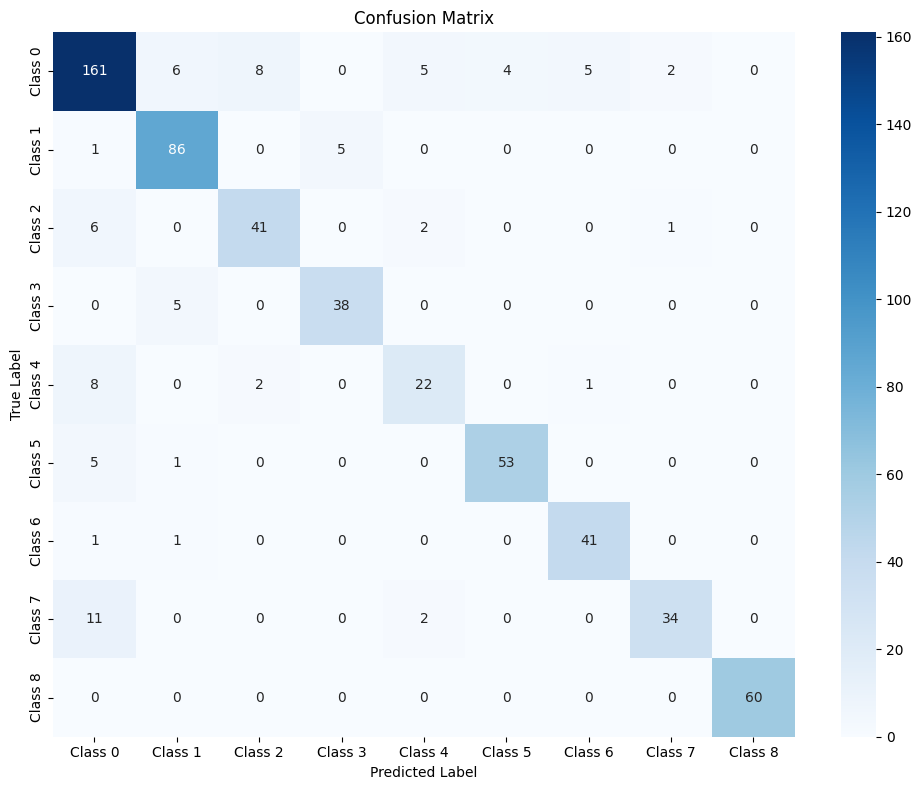

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
NUM_CLASSES = 9
class_names = [f"Class {i}" for i in range(NUM_CLASSES)]

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
TARGET_HEIGHT

224

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

TEST_FOLDER = "/content/drive/MyDrive/challenge_deep/datatest"

#TARGET_HEIGHT = 800
#TARGET_WIDTH  = 800

def load_and_preprocess_image(filepath):
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    return image

test_files = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.lower().endswith('.jpg')]
print(f"Found {len(test_files)} test images.")

predictions = []

for filepath in test_files:
    image = load_and_preprocess_image(filepath)
    image = tf.expand_dims(image, axis=0)

    preds = model.predict(image)
    pred_label = int(np.argmax(preds, axis=1)[0])

    idx = os.path.splitext(os.path.basename(filepath))[0]

    predictions.append({'idx': idx, 'gt': pred_label})

pred_df = pd.DataFrame(predictions)
pred_df.to_csv("predictions_convenxt.csv", index=False)
print("Saved predictions_v0.csv")


Found 1344 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
data_label_inference

,image_name,label,x_center,y_center,width,height,_merge
0,0.227249003819710140.78286216702899760.3175101...,0,0.157878,0.650391,0.187500,0.531250,left_only
4,0.62959327540824830.064861203841840580.5070058...,2,0.101562,0.530029,0.159505,0.402832,left_only
29,0.335311481026566270.50712371620590190.7976991...,5,0.490560,0.245605,0.221354,0.405273,left_only
30,0.335311481026566270.50712371620590190.7976991...,5,0.180501,0.489746,0.187174,0.454102,left_only
32,0.99283287812430950.238644541496487280.6433934...,6,0.536947,0.525146,0.841471,0.637207,left_only
...,...,...,...,...,...,...,...
1347,0.65236466665291410.9068882284036550.770509000...,0,0.218750,0.497070,0.237630,0.439453,left_only
1365,0.26402895558768760.96252679730330.46927208894...,0,0.470215,0.497070,0.415039,0.366211,left_only
1376,0.135111386750685460.57206416328635530.1489235...,0,0.327474,0.598877,0.184896,0.350098,left_only
1387,0.99670287684859240.91925559149021340.73946437...,0,0.468099,0.305664,0.417318,0.548828,left_only


In [ ]:
data_label_inference

,image_name,label,x_center,y_center,width,height,_merge
0,0.227249003819710140.78286216702899760.3175101...,0,0.157878,0.650391,0.187500,0.531250,left_only
4,0.62959327540824830.064861203841840580.5070058...,2,0.101562,0.530029,0.159505,0.402832,left_only
29,0.335311481026566270.50712371620590190.7976991...,5,0.490560,0.245605,0.221354,0.405273,left_only
30,0.335311481026566270.50712371620590190.7976991...,5,0.180501,0.489746,0.187174,0.454102,left_only
32,0.99283287812430950.238644541496487280.6433934...,6,0.536947,0.525146,0.841471,0.637207,left_only
...,...,...,...,...,...,...,...
1347,0.65236466665291410.9068882284036550.770509000...,0,0.218750,0.497070,0.237630,0.439453,left_only
1365,0.26402895558768760.96252679730330.46927208894...,0,0.470215,0.497070,0.415039,0.366211,left_only
1376,0.135111386750685460.57206416328635530.1489235...,0,0.327474,0.598877,0.184896,0.350098,left_only
1387,0.99670287684859240.91925559149021340.73946437...,0,0.468099,0.305664,0.417318,0.548828,left_only


In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

#TARGET_HEIGHT = 224
#TARGET_WIDTH  = 224
#IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406])
#IMAGENET_STD  = tf.constant([0.229, 0.224, 0.225])

def decode_and_crop_image_only(image_path, x_center, y_center, w_rel, h_rel):
    x_center, y_center, w_rel, h_rel = [tf.cast(v, tf.float32) for v in [x_center, y_center, w_rel, h_rel]]

    image_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image_bytes, channels=3)

    shape = tf.shape(image)
    img_h, img_w = tf.cast(shape[0], tf.float32), tf.cast(shape[1], tf.float32)

    x1 = tf.cast(tf.math.round((x_center - w_rel / 2.0) * img_w), tf.int32)
    y1 = tf.cast(tf.math.round((y_center - h_rel / 2.0) * img_h), tf.int32)
    box_w = tf.cast(tf.math.round(w_rel * img_w), tf.int32)
    box_h = tf.cast(tf.math.round(h_rel * img_h), tf.int32)

    x1 = tf.clip_by_value(x1, 0, tf.cast(img_w - 1, tf.int32))
    y1 = tf.clip_by_value(y1, 0, tf.cast(img_h - 1, tf.int32))
    x2 = tf.clip_by_value(x1 + box_w, 0, tf.cast(img_w, tf.int32))
    y2 = tf.clip_by_value(y1 + box_h, 0, tf.cast(img_h, tf.int32))

    cropped = tf.image.crop_to_bounding_box(image, y1, x1, y2 - y1, x2 - x1)
    cropped = tf.image.resize_with_pad(cropped, TARGET_HEIGHT, TARGET_WIDTH)

    cropped = cropped / 255.0
    cropped = (cropped - IMAGENET_MEAN) / IMAGENET_STD

    return cropped

def build_inference_dataset(df, images_dir, batch_size=4):
    image_paths = df["image_name"].apply(lambda x: os.path.join(images_dir, f"{x}.jpg")).values
    image_names = df["image_name"].values
    x_centers   = df["x_center"].values
    y_centers   = df["y_center"].values
    widths      = df["width"].values
    heights     = df["height"].values

    dataset = tf.data.Dataset.from_tensor_slices((
         image_paths, image_names, x_centers, y_centers, widths, heights
    ))

    def map_fn(ip, iname, xc, yc, w, h):
         processed_image = decode_and_crop_image_only(ip, xc, yc, w, h)
         return processed_image, iname, xc, yc, w, h

    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

inference_ds = build_inference_dataset(data_label_inference, IMAGES_FOLDER, batch_size=8)

predictions = []

for batch in inference_ds:
    images, image_names, x_centers, y_centers, widths, heights = batch
    preds = model.predict(images)

    for i in range(preds.shape[0]):
        sample_dict = {
            "image_name": image_names[i].numpy().decode("utf-8") if isinstance(image_names[i].numpy(), bytes) else image_names[i].numpy(),
            "x_center": float(x_centers[i].numpy()),
            "y_center": float(y_centers[i].numpy()),
            "width": float(widths[i].numpy()),
            "height": float(heights[i].numpy())
        }
        # Add softmax probabilities for each class
        for j, prob in enumerate(preds[i]):
            sample_dict[f"logit_class_{j}"] = float(prob)

        predictions.append(sample_dict)

pred_df = pd.DataFrame(predictions)
pred_df.to_csv("predictions_inference.csv", index=False)
print("Inference predictions saved to predictions_inference.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Inference predictions saved to predictions_inferen

### Logit for convnext

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

TEST_FOLDER = "/content/drive/MyDrive/challenge_deep/datatest"


def load_and_preprocess_image(filepath):
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH)
    image = image / 255.0  
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    return image

test_files = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.lower().endswith('.jpg')]
print(f"Found {len(test_files)} test images.")

all_logits = []

for filepath in test_files:
    image = load_and_preprocess_image(filepath)
    image = tf.expand_dims(image, axis=0)

    preds = model.predict(image)
    logits = preds[0]

    idx = os.path.splitext(os.path.basename(filepath))[0]

    all_logits.append({'idx': idx, **{f'logit_class_{i}': logit for i, logit in enumerate(logits)}})

logits_df = pd.DataFrame(all_logits)
logits_df.to_csv("predictions_logits_v0.csv", index=False)
print("Saved predictions_logits_v0.csv")

Found 1344 test images.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

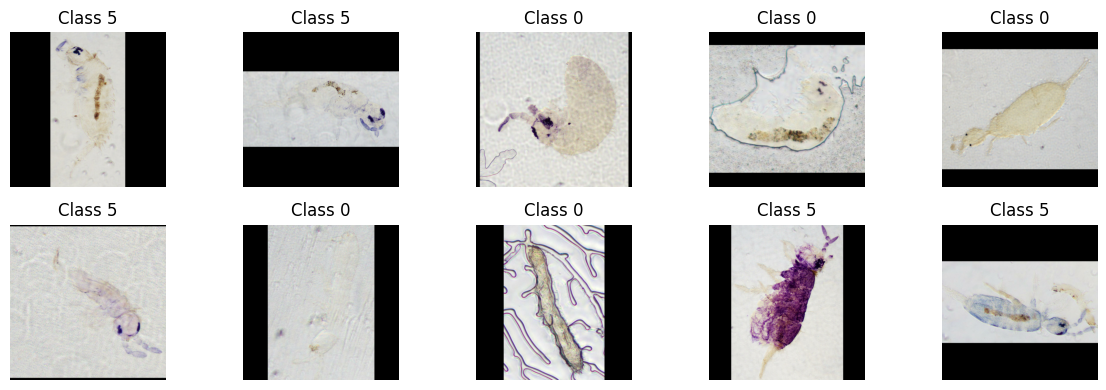

In [ ]:
import matplotlib.pyplot as plt

# How many images to display per class
num_to_show = 5
target_classes = [0, 5]

# Counters for how many we've shown per class
shown = {cls: 0 for cls in target_classes}

plt.figure(figsize=(12, 4))

i = 1  # subplot index
for images, labels in test_ds:
    for img, label in zip(images, labels):
        label = int(label.numpy())
        if label in target_classes and shown[label] < num_to_show:
            plt.subplot(2, num_to_show, i)
            plt.imshow(img.numpy())
            plt.title(f"Class {label}")
            plt.axis("off")
            shown[label] += 1
            i += 1

            # Stop if we've shown enough for all classes
            if all(count >= num_to_show for count in shown.values()):
                break
    if all(count >= num_to_show for count in shown.values()):
        break

plt.tight_layout()
plt.show()